# Introduction to the refactored SN shell model

I have refactored Ivan's code. It is now written in Python and organised in an object oriented fashion to allow easy extension. Parts of the calculation were accelerated using [numba](https://numba.pydata.org/).

## Setting the scene

First, some basic imports:

In [1]:
import os, sys
sys.path.append('../')

from shell import ShellModel, FieldTransformer
import shell.observable as obs
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import imagine as img

The model for the SN shell formation/evolution is taken care of by the ShellModel class. 
Below this is initialized with its default parameters (which characterise the shell properties).

In [2]:
shell_model = ShellModel(V0=0.0153*u.pc/u.yr,
                         a=1.3, b=10, R=50*u.pc,
                         elapsed_time=1300*u.yr)

(this object provides the methods `initial_radius` and `dr_dr0` which are used in the later transformtions)

For convenience, the coordinates are specified using an [IMAGINE's grid object](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html?highlight=grid#imagine.fields.grid.UniformGrid). Such object can be initialized in the following way:

In [3]:
L = 70*u.pc
N = 128

grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])

With the coordinate grid and the model for the shell evolution, we have all the elements to transform a magnetic field or a density field. This procedure is performed by the `FieldTransformer` class, which has first to be initialized.

In [4]:
field_transformer = FieldTransformer(grid, shell_model)

## Preparing the model

Given some initial ambient magnetic field and density field, this object can produce the magnetic field and density on a shell after the SN explosion. 

Let us now construct a model for the initial density field

In [5]:
n0 = np.ones(grid.shape) * u.cm**(-3) # Constant unit density

This can be substituted by any complicated array...

Likewise, let us illustrate an initial magnetic field with a constant field

In [6]:
Bx0 = np.ones(grid.shape) * u.microgauss
By0 = Bx0
Bz0 = Bx0

again, we can substitute this field by anything we imagine.

The field and density after the SN explosion is computed by the following line:

In [7]:
n, [Bx, By, Bz] = field_transformer(n0, [Bx0, By0, Bz0])

## Plotting the model 

Let us plot those to see what we get. First I will define some handy plotting routines.

In [8]:
def get_latex_units(q):
    return q.unit._repr_latex_().replace('$','')

def plot_scalar_xy(grid, scalar_field, name='n',
                   pos=40, ax=None, fig=None):
    """
    Plots a slice of a scalar field defined on a 3D cartesian grid
    """
    if ax is None:
        if fig is None:
            fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111)
        
    if len(scalar_field.shape)==3:
        im_slice = scalar_field[:,:,pos]
    else:
        im_slice = scalar_field
        
    im = ax.contourf(grid.x[:,:,pos],grid.y[:,:,pos], im_slice)
    ax.set_aspect(1)
    ax.set_xlabel(r'$x\;[\rm pc]$')
    ax.set_ylabel(r'$y\;[\rm pc]$')
    cax = plt.colorbar(im, ax=ax)
    cax.set_label(r'${}\;\left[\,{}\,\right]$'.format(name,
                                  get_latex_units(scalar_field)))
    return fig
    
def plot_vector_xy(grid, vector_field, skip=3, name=r'\mathbf{B}',
                   pos=40, ax=None, fig=None, show_z_component=False,
                   quiver_color='orange', contour_alpha=1,**kwargs):
    """
    Plots a slice of a vector field defined on a 3D cartesian grid
    """
    if ax is None:
        if fig is None:
            fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111)
    
    Bx, By, Bz = vector_field
    if show_z_component:
        B = Bz
        vmax = np.max(np.abs(Bz.value))
        if ('vmin' not in kwargs) and ('vmax' not in kwargs):
            kwargs['vmin'] = -vmax
            kwargs['vmax'] = vmax
        if 'cmap' not in kwargs:
            kwargs['cmap'] = 'coolwarm'
    else:
        B = np.sqrt(Bx**2+By**2+Bz**2)
        name = '|'+name+'|'
    
    im = ax.contourf(grid.x[:,:,pos],grid.y[:,:,pos], B[:,:,pos], 
                     alpha=contour_alpha, **kwargs)
    # Quiver does not handle units well. Does, we select the values instead
    ax.quiver(grid.x[::skip,::skip,pos].value, grid.y[::skip,::skip,pos].value, 
           Bx[::skip,::skip,pos].value, By[::skip,::skip,pos].value, color=quiver_color)

    ax.set_aspect(1)
    ax.set_xlabel(r'$x\;[\rm pc]$')
    ax.set_ylabel(r'$y\;[\rm pc]$')
    cax = plt.colorbar(im, ax=ax)
    cax.set_label(r'${}\;\left[\,{}\,\right]$'.format(name, get_latex_units(B)))
    return fig

Now we can examine our results

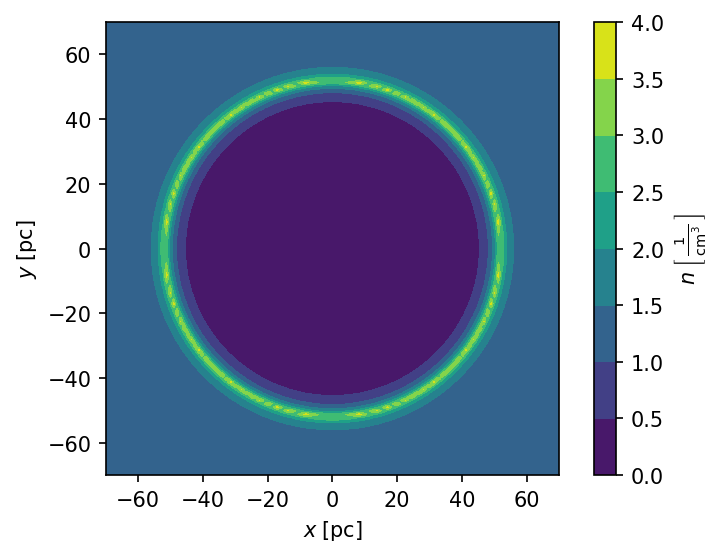

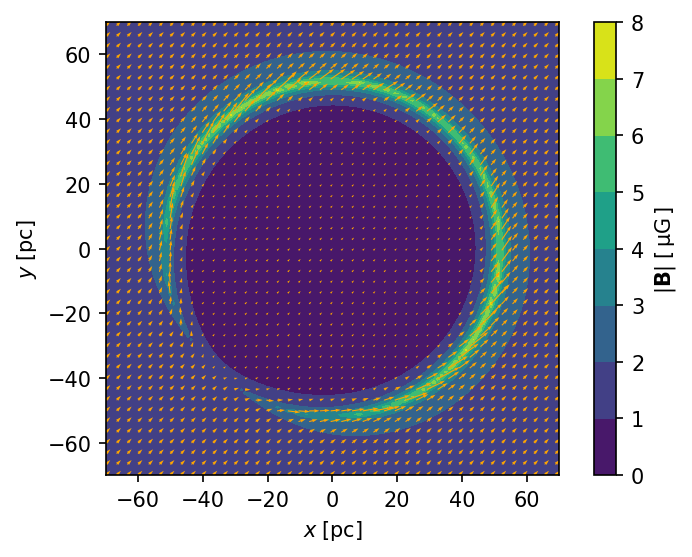

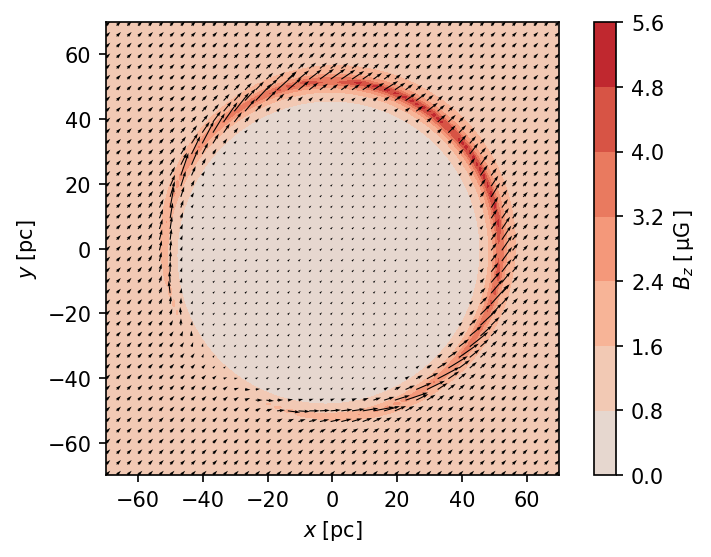

In [9]:
plot_scalar_xy(grid, n)
plot_vector_xy(grid, [Bx, By, Bz])
plot_vector_xy(grid, [Bx, By, Bz], name='B_z',
               quiver_color='black', show_z_component=True);

## Computing observables

In [10]:
lamb = 20*u.cm
ne = n
ncr = 1*u.cm**-3

I, U, Q = obs.compute_stokes_parameters(grid, lamb, Bx, By, Bz, ne, ncr)

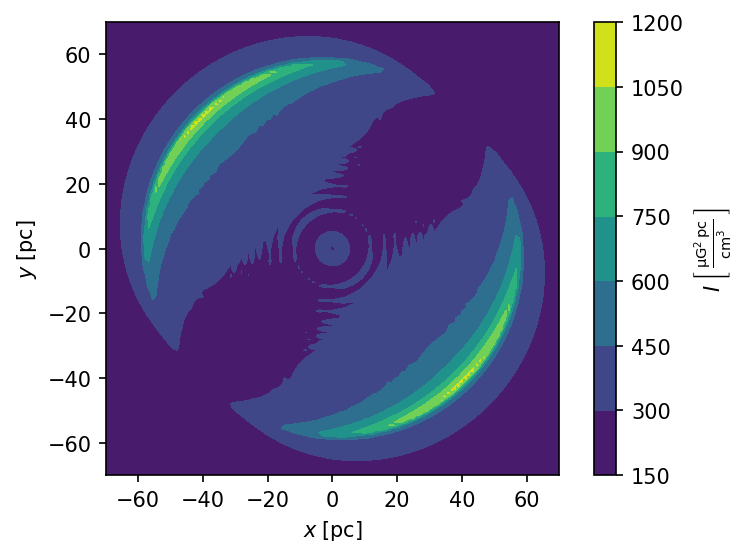

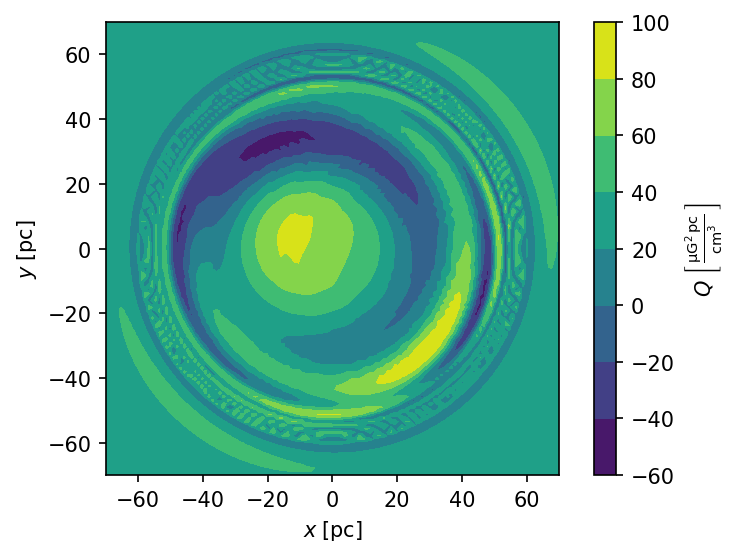

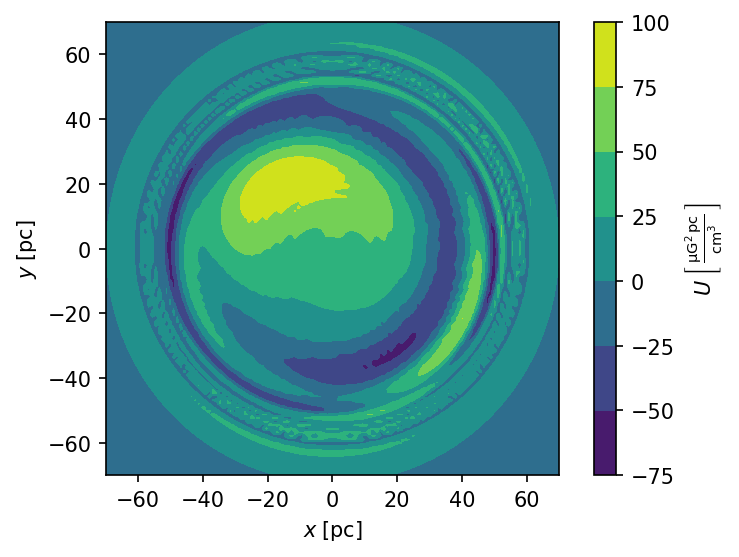

In [11]:
plot_scalar_xy(grid, I,name='I')
plot_scalar_xy(grid, Q,name='Q')
plot_scalar_xy(grid, U,name='U');

In [12]:
fraction = np.sqrt((Q**2+U**2)/I**2)

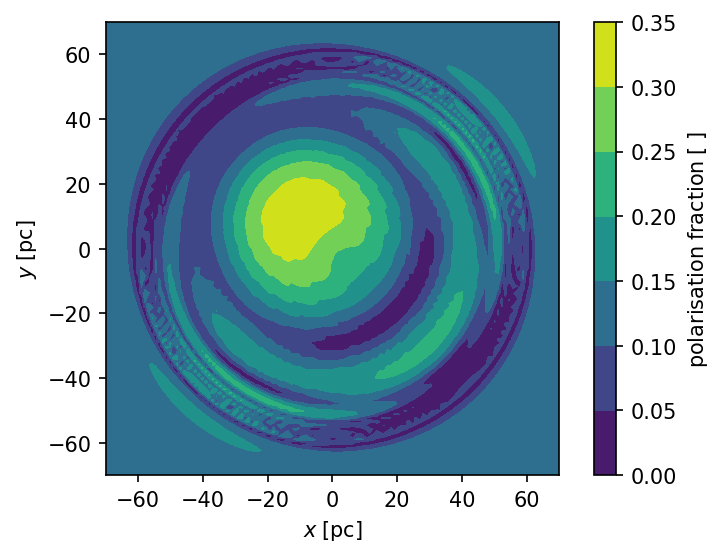

In [13]:
plot_scalar_xy(grid, fraction, name=r'{\rm polarisation\;fraction}');